In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import os
import bambi

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
target_folder = op.join(bids_folder, f'derivatives/cogmodels_magjudge')
plot_folder = op.join(bids_folder, 'plots_and_ims', 'behavior_magjudge')

sns.set_context('talk')

from utils import get_data

df = get_data(bids_folder)
df['x'] = df['log(n2/n1)'] 

group_list = df.reset_index().drop_duplicates(subset=['subject', 'group'])[['subject', 'group']]


number of subjects found: 66
number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [32]:
model_label = 1
model = bambi.Model('chose_n2 ~ x + x*group + (x|subject)', link='probit', family='bernoulli', data=df.reset_index())

In [2]:
model_label = 2
model = bambi.Model('chose_n2 ~ x + x*n1*group + (x*n1|subject)', link='probit', family='bernoulli', data=df.reset_index())

### fit

In [25]:
import arviz as az

traces = model.fit(init='adapt_diag', target_accept=0.9, draws=1000, tune=1000)

az.to_netcdf(traces, op.join(target_folder, f'probit_model-{model_label}_trace.netcdf'))

Modeling the probability that chose_n2==1
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x, n1, x:n1, group, x:group, n1:group, x:n1:group, 1|subject_sigma, 1|subject_offset, x|subject_sigma, x|subject_offset, n1|subject_sigma, n1|subject_offset, x:n1|subject_sigma, x:n1|subject_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 260 seconds.


'/Users/mrenke/data/ds-dnumrisk/derivatives/cogmodels_magjudge/probit_model-2_trace.netcdf'

### load in trace

In [3]:
import arviz as az

model_label = 2

traces = az.from_netcdf( op.join(target_folder, f'probit_model-{model_label}_trace.netcdf'))


2
Intercept: mean=-0.40437366242013745, 95%CI=[-0.53631341 -0.27289071]
x: mean=5.328738339794891, 95%CI=[4.78816969 5.8702809 ]
n1: mean=0.03426855188141974, 95%CI=[0.02425891 0.04460338]
x:n1: mean=-0.10129796960244809, 95%CI=[-0.13040064 -0.07223313]
group: mean=-0.09859768587327673, 95%CI=[-0.28514108  0.09107274]
x:group: mean=-0.5751384399598628, 95%CI=[-1.30818567  0.16105182]
n1:group: mean=0.013102677868606508, 95%CI=[-0.00106698  0.02753195]
x:n1:group: mean=0.02962000773530566, 95%CI=[-0.01101106  0.06960666]


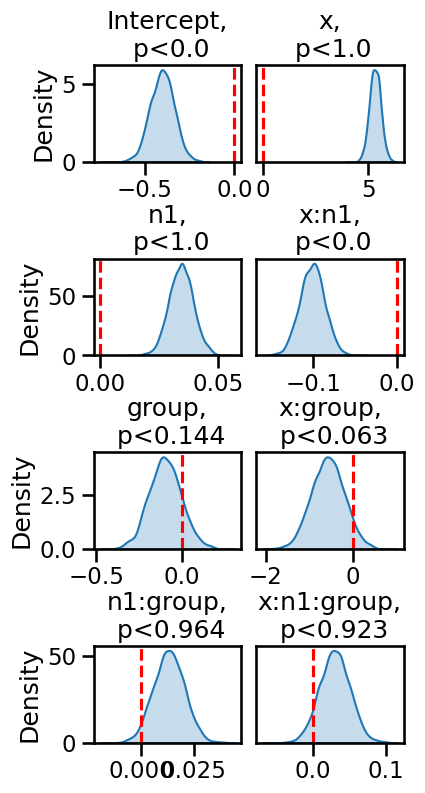

In [41]:
print(model_label)

variable_names = list(traces.posterior.data_vars.keys())  # variable_names = list(traces.posterior.data_vars.keys()) 
variable_names = [x for x in variable_names if 'subject' not in x] # remove sd

n_rows = int(len(variable_names) / 2 )
fig, axs = plt.subplots(n_rows,2, figsize=(4,n_rows * 2.2), sharex=False)

for i in range(n_rows):
    for j in range(2): # intercept & slope 
        index = i * 2 + j
        var = variable_names[index] # goes till 7/8
        temp = traces.posterior[var].to_dataframe()
        count_greater_zero = np.round(np.mean(temp[var] > 0),3)
        sns.kdeplot(temp, ax=axs[i, j],legend=False, fill=True)
        if j!= 0:
            axs[i, j].set(yticks=[],ylabel='')
        axs[i, j].axvline(x=0, color='r', linestyle='--')
        axs[i, j].set_title(f'{var},\n p<{count_greater_zero}')
        print(f'{var}: mean={temp[var].mean()}, 95%CI={np.percentile(temp[var], [2.5, 97.5])}')

fig.subplots_adjust(wspace=0.1, hspace=1)
plt.savefig(op.join(plot_folder, f'probit_model-{model_label}_regressors.pdf'))

In [90]:
import scipy.stats as ss

def invprobit(x):
    return ss.norm.ppf(x)

def extract_rnp_precision(trace, model, data, group_level = False):

    data = data.reset_index()

    reg_list = [data.reset_index()['subject'].unique(),[0, 1], data['n1'].unique(), data['group'].unique()]
    names=['subject', 'x', 'n1','group']
    
    if group_level: # needed 
        include_group_specific = None
    else:     # when no subjects! include_group_specific=False
        include_group_specific = True 

    fake_data = pd.MultiIndex.from_product(reg_list,names=names).to_frame().reset_index(drop=True)

    pred = model.predict(trace, 'mean', fake_data, inplace=False, include_group_specific=include_group_specific)['posterior']['chose_n2_mean']

    pred = pred.to_dataframe().unstack([0, 1])
    pred = pred.set_index(pd.MultiIndex.from_frame(fake_data))

    # return pred

    pred0 = pred.xs(0, 0, 'x')
    intercept = pd.DataFrame(invprobit(pred0), index=pred0.index, columns=pred0.columns)
    gamma = invprobit(pred.xs(1, 0, 'x')) - intercept

    return intercept, gamma


In [91]:
#from utils import extract_rnp_precision

intercept, gamma= extract_rnp_precision(traces, model,df, group_level = False) # ,group=False for subs

intercept = intercept.stack([1, 2])
intercept.columns = ['intercept']

gamma = gamma.stack([1, 2])
gamma.columns = ['gamma']

### group level

<AxesSubplot: xlabel='n1', ylabel='intercept'>

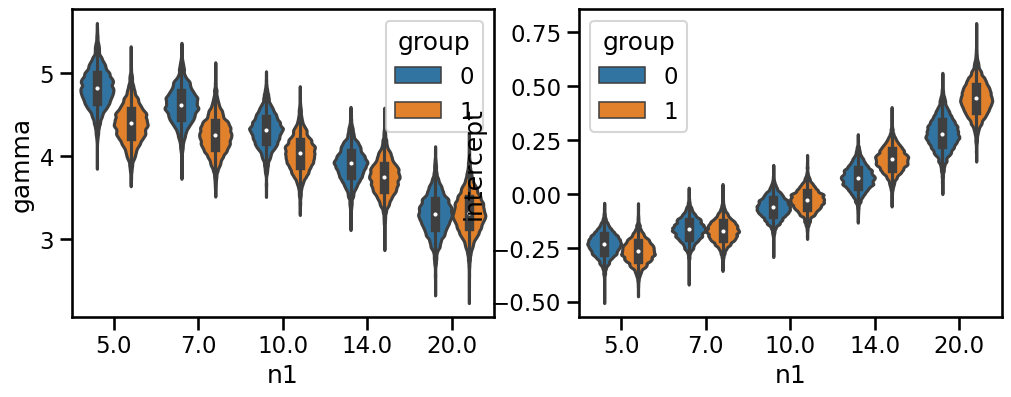

In [49]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.violinplot(data=gamma.reset_index(), x='n1',y='gamma',hue='group',ax=axs[0])
sns.violinplot(data=intercept.reset_index(), x='n1',y='intercept',hue='group',ax=axs[1])


Text(51.0, 0.5, 'density - gamma')

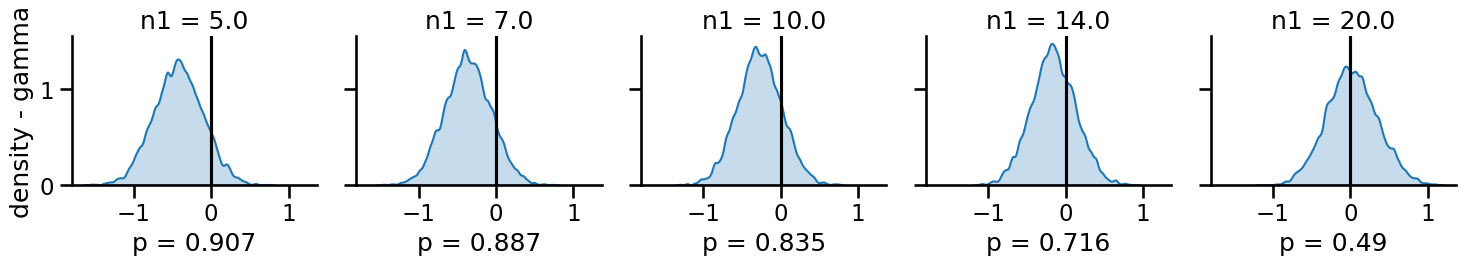

In [85]:
temp = gamma.unstack('group').droplevel(0, axis=1)
diff = (temp[1] - temp[0]).to_frame('diff')
g = sns.FacetGrid(diff.reset_index(),col='n1' )
g.map(sns.kdeplot, 'diff', fill=True)
g.map(plt.axvline, x=0.0,c='k')

for i,n1 in enumerate(diff.index.unique('n1').values):
    d = diff.xs(n1, 0,'n1')
    p_val = np.round(((d<0.0).mean())[0], 3)
    g.axes[0][i].set_xlabel(f'p = {p_val}')
g.axes[0][0].set_ylabel('density - gamma')


Text(51.0, 0.5, 'density - intercept')

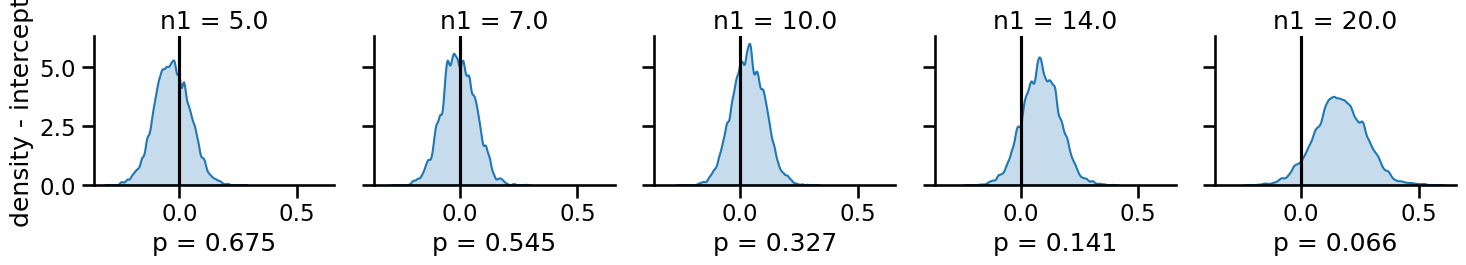

In [86]:
temp = intercept.unstack('group').droplevel(0, axis=1)
diff = (temp[1] - temp[0]).to_frame('diff')
g = sns.FacetGrid(diff.reset_index(),col='n1' )
g.map(sns.kdeplot, 'diff', fill=True)
g.map(plt.axvline, x=0.0,c='k')


for i,n1 in enumerate(diff.index.unique('n1').values):
    d = diff.xs(n1, 0,'n1')
    p_val = np.round(((d<0.0).mean())[0], 3)
    g.axes[0][i].set_xlabel(f'p = {p_val}')
g.axes[0][0].set_ylabel('density - intercept')


#### subject level

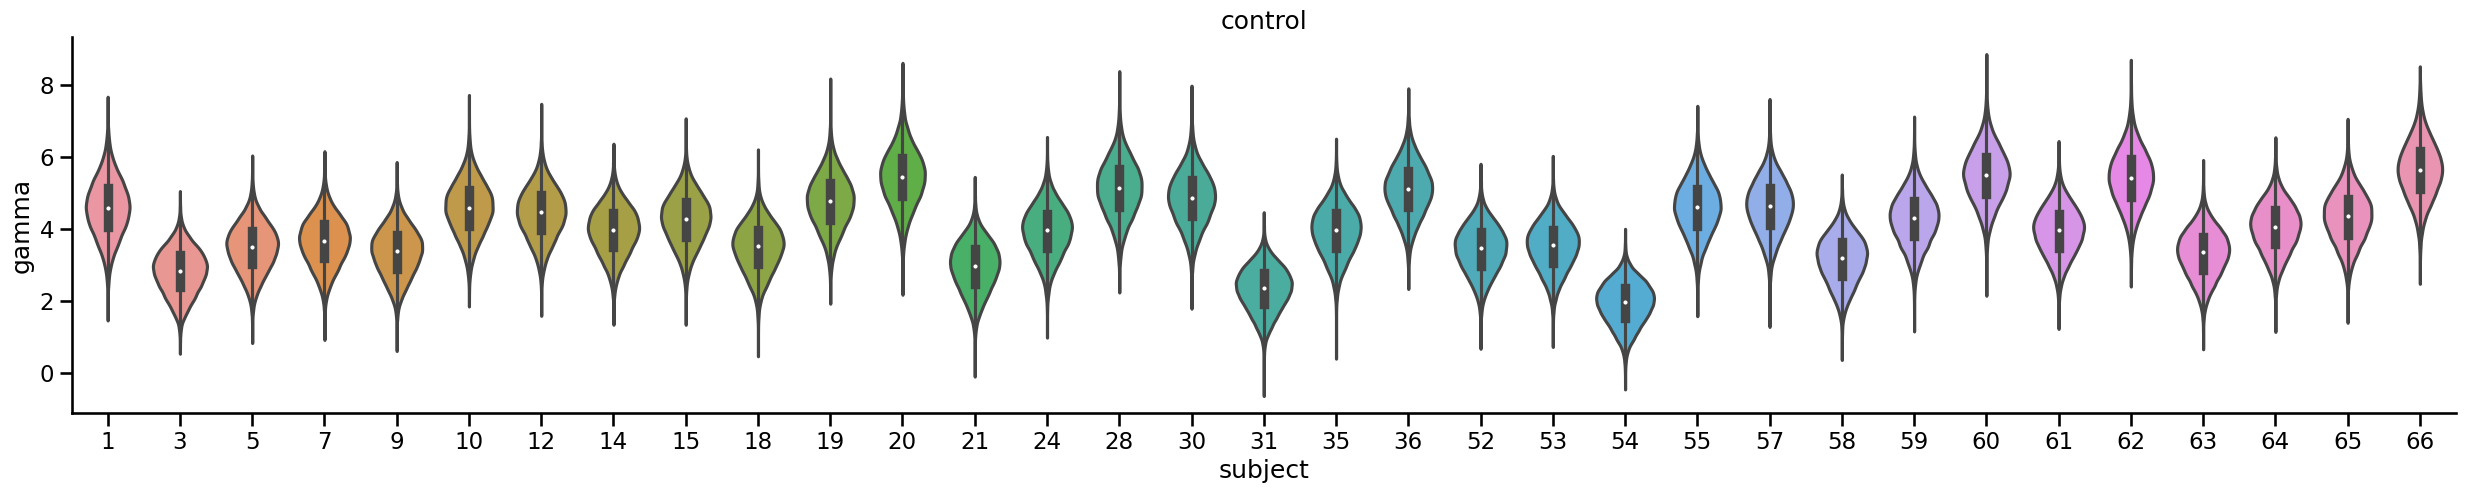

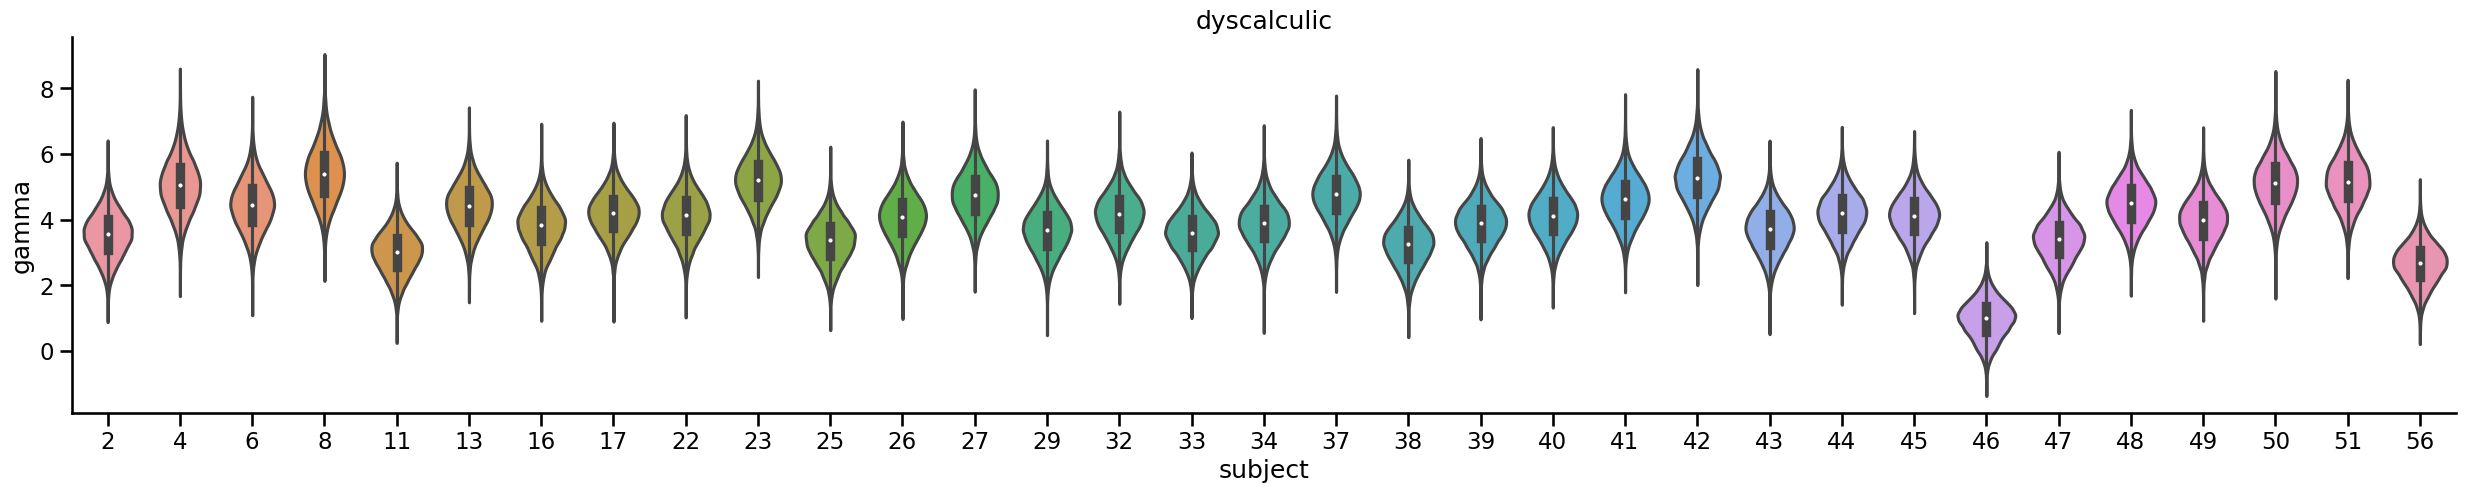

In [92]:

for i, group in enumerate(['control','dyscalculic']):
    sub_list = group_list[group_list['group'] == i]['subject'].unique()
    temp = gamma[gamma.index.get_level_values('subject').isin(sub_list)]

    fac = sns.catplot(x='subject', y='gamma', data=temp.reset_index(), aspect=5., kind='violin')
    fac.set(title=f'{group}') 

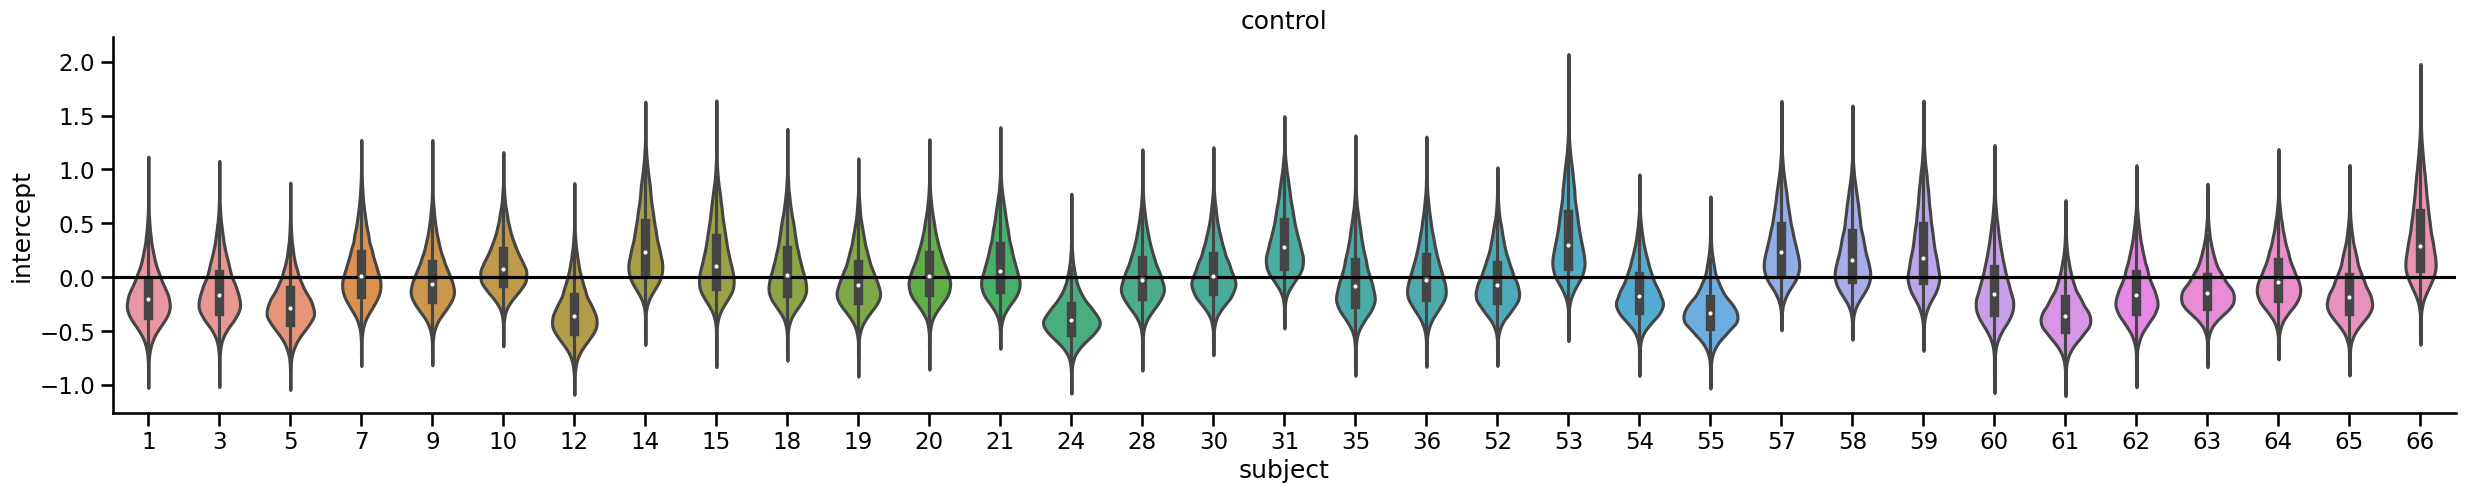

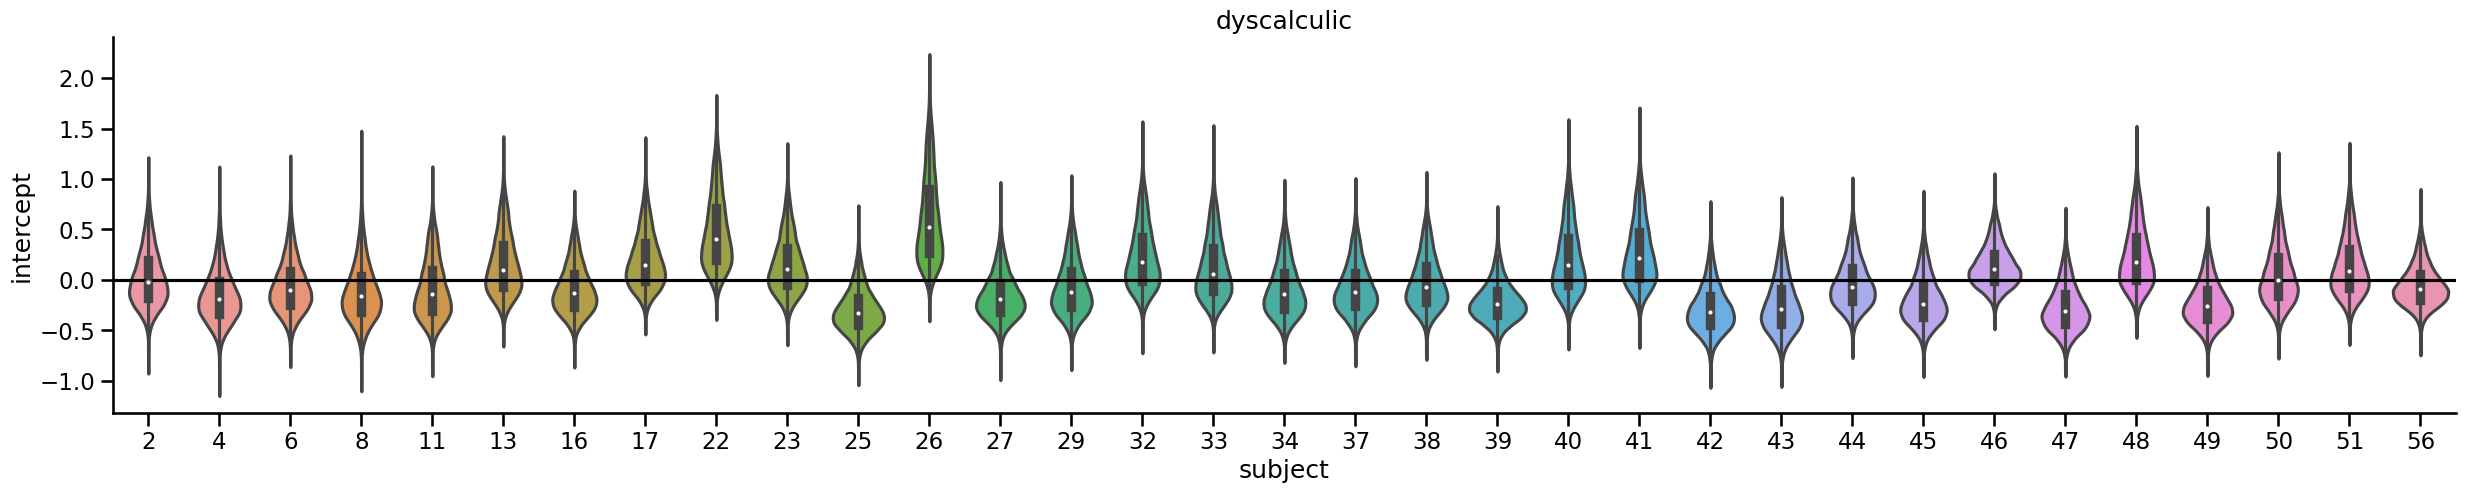

In [96]:

for i, group in enumerate(['control','dyscalculic']):
    sub_list = group_list[group_list['group'] == i]['subject'].unique()
    temp = intercept[intercept.index.get_level_values('subject').isin(sub_list)]

    fac = sns.catplot(x='subject', y='intercept', data=temp.reset_index(), aspect=5., kind='violin')
    plt.axhline(0, c='k')
    fac.set(title=f'{group}') #, ylabel='Risk neutral probability')
    #fac.add_legend()

In [97]:
traces.posterior['n1|subject'].to_dataframe()

n1|subject
chain draw subject__factor_dim            
0     0    1                     -0.018590
           2                     -0.024665
           3                      0.002794
           4                     -0.008414
           5                     -0.007794
...                                    ...
3     999  62                    -0.017896
           63                     0.003711
           64                     0.005147
           65                     0.006774
           66                     0.022466

[264000 rows x 1 columns]

In [ ]:
for i, group in enumerate(['control','dyscalculic']):
    plt.figure()
    sub_list = group_list[group_list['group'] == i]['subject'].unique()
    temp = rnp[rnp.index.get_level_values('subject').isin(sub_list)]

    fac = sns.catplot(x='subject', y='rnp', data=temp.reset_index(), hue='format', aspect=5., kind='violin')
    plt.ylim(0, 1)
    plt.axhline(.55, c='k', ls='--', label='risk-neutral')
    fac.set(title=f'{group}', ylabel='Risk neutral probability')
    fac.add_legend()

In [10]:
temp

intercept
subject n1   group chain draw           
14      14.0 1     0     0      3.694838
                         1      3.544520
                         2      3.541528
                         3      3.804272
                         4      3.683589
...                                  ...
57      20.0 0     3     995    3.714158
                         996    3.894951
                         997    3.832907
                         998    4.032446
                         999    4.090574

[1320000 rows x 1 columns]

## PPCs

In [34]:
def format_bambi_ppc(trace, model, df):

    preds = []
    for key, kind in zip(['ll_bernoulli', 'p'], ['pps', 'mean']):
        pred = model.predict(trace, kind=kind, inplace=False) 
        if kind == 'pps':
            pred = pred['posterior_predictive']['chose_n2'].to_dataframe().unstack(['chain', 'draw'])['chose_n2']
        else:
            pred = pred['posterior']['chose_n2_mean'].to_dataframe().unstack(['chain', 'draw'])['chose_n2_mean']
        pred.index = df.index
        pred = pred.set_index(pd.MultiIndex.from_frame(df), append=True)
        preds.append(pred)

    pred = pd.concat(preds, keys=['ll_bernoulli', 'p'], names=['variable'])
    return pred

In [35]:
from utils_03 import  summarize_ppc, plot_ppc, format_bambi_ppc

ppc = format_bambi_ppc(traces, model, df)
summarize_ppc(ppc, groupby=None)


/Users/mrenke/git/numrisk/numrisk/behavior_magjudge/utils_03.py:90: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


p_predicted  \
variable     subject run trial_nr rt       n1   n2   choice chose_n2 frac     log(n2/n1) log(n1)  group x                        
ll_bernoulli 13      1   1        1.940046 14.0 11.0 False  False    0.785714 -0.241162  2.639057 1     -0.241162     0.234000   
                         2        1.088813 14.0 15.0 True   True     1.071429  0.068993  2.639057 1      0.068993     0.670000   
                         3        1.187995 7.0  8.0  True   True     1.142857  0.133531  1.945910 1      0.133531     0.757750   
                         4        1.805343 14.0 10.0 False  False    0.714286 -0.336472  2.639057 1     -0.336472     0.129000   
                         5        1.788309 10.0 6.0  False  False    0.600000 -0.510826  2.302585 1     -0.510826     0.032750   
...                                                                                                                        ...   
p            57      6   176      1.304741 14.0 18.0 True   True     1.285714  0.251314  2.639057 0      0.251314     0.919230   
                         177      1.171379 7.0  4.0  False  False    0.571429 -0.559616  1.945910 0     -0.559616     0.017297   
                         178      1.121492 7.0  4.0  False  False    0.571429 -0.559616  1.945910 0     -0.559616     0.017297   
                         179      4.541196 20.0 11.0 False  False    0.550000 -0.597837  2.995732 0     -0.597837     0.011635   
                         180      1.471818 10.0 9.0  False  False    0.900000 -0.105361  2.302585 0     -0.105361     0.435649   

                                                                                                                     hdi025  \
variable     subject run trial_nr rt       n1   n2   choice chose_n2 frac     log(n2/n1) log(n1)  group x                     
ll_bernoulli 13      1   1        1.940046 14.0 11.0 False  False    0.785714 -0.241162  2.639057 1     -0.241162  0.000000   
                         2        1.088813 14.0 15.0 True   True     1.071429  0.068993  2.639057 1      0.068993  0.000000   
                         3        1.187995 7.0  8.0  True   True     1.142857  0.133531  1.945910 1      0.133531  0.000000   
                         4        1.805343 14.0 10.0 False  False    0.714286 -0.336472  2.639057 1     -0.336472  0.000000   
                         5        1.788309 10.0 6.0  False  False    0.600000 -0.510826  2.302585 1     -0.510826  0.000000   
...                                                                                                                     ...   
p            57      6   176      1.304741 14.0 18.0 True   True     1.285714  0.251314  2.639057 0      0.251314  0.869119   
                         177      1.171379 7.0  4.0  False  False    0.571429 -0.559616  1.945910 0     -0.559616  0.002027   
                         178      1.121492 7.0  4.0  False  False    0.571429 -0.559616  1.945910 0     -0.559616  0.002027   
                         179      4.541196 20.0 11.0 False  False    0.550000 -0.597837  2.995732 0     -0.597837  0.000986   
                         180      1.471818 10.0 9.0  False  False    0.900000 -0.105361  2.302585 0     -0.105361  0.348124   

                                                                                                                     hdi975  
variable     subject run trial_nr rt       n1   n2   choice chose_n2 frac     log(n2/n1) log(n1)  group x                    
ll_bernoulli 13      1   1        1.940046 14.0 11.0 False  False    0.785714 -0.241162  2.639057 1     -0.241162  1.000000  
                         2        1.088813 14.0 15.0 True   True     1.071429  0.068993  2.639057 1      0.068993  1.000000  
                         3        1.187995 7.0  8.0  True   True     1.142857  0.133531  1.945910 1      0.133531  1.000000  
                         4        1.805343 14.0 10.0 False  False    0.714286 -0.336472  2.639057 1     -0.336472  1.000000  
                

In [36]:
level = 'group' # 'subject'
for plot_type in [1,2,3]:
    plot_ppc(df, ppc,level=level, plot_type=plot_type)
    plt.savefig(op.join(plot_folder, f'ppc_rnp_model-{model_label}_plot-{plot_type}_{level}.pdf'))
    plt.close()

/Users/mrenke/git/numrisk/numrisk/behavior_magjudge/utils_03.py:90: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


    group  log(n2/n1)  p_predicted  hdi025  hdi975  chose_n2  Prop. chosen n2
0       0   -1.609438     0.000017     0.0     0.0  0.000000         0.000000
1       0   -1.252763     0.000178     0.0     0.0  0.022222         0.022222
2       0   -1.203973     0.000233     0.0     0.0  0.000000         0.000000
3       0   -1.049822     0.001083     0.0     0.0  0.000000         0.000000
4       0   -1.029619     0.001000     0.0     0.0  0.000000         0.000000
..    ...         ...          ...     ...     ...       ...              ...
85      1    0.854415     0.998792     1.0     1.0  1.000000         1.000000
86      1    0.857450     0.998646     1.0     1.0  1.000000         1.000000
87      1    0.998529     0.999750     1.0     1.0  1.000000         1.000000
88      1    1.024504     0.999854     1.0     1.0  1.000000         1.000000
89      1    1.029619     0.999722     1.0     1.0  1.000000         1.000000

[90 rows x 7 columns]


/Users/mrenke/git/numrisk/numrisk/behavior_magjudge/utils_03.py:90: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


   group    n1  p_predicted    hdi025    hdi975  chose_n2  Prop. chosen n2
0      0   5.0     0.428287  0.409456  0.446637  0.378749         0.378749
1      0   7.0     0.448549  0.430473  0.467051  0.425297         0.425297
2      0  10.0     0.464626  0.445022  0.483732  0.456020         0.456020
3      0  14.0     0.472319  0.453660  0.490806  0.504697         0.504697
4      0  20.0     0.483484  0.463057  0.501977  0.528559         0.528559
5      1   5.0     0.432703  0.412324  0.451967  0.357576         0.357576
6      1   7.0     0.452366  0.432714  0.472371  0.423509         0.423509
7      1  10.0     0.473951  0.451410  0.493873  0.459622         0.459622
8      1  14.0     0.481848  0.462142  0.501859  0.524422         0.524422
9      1  20.0     0.491351  0.471816  0.512679  0.560515         0.560515


/Users/mrenke/git/numrisk/numrisk/behavior_magjudge/utils_03.py:90: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


     group    n1  log(n2/n1)  p_predicted    hdi025    hdi975  chose_n2  \
0        0   5.0   -1.609438     0.000017  0.000000  0.000000  0.000000   
1        0   5.0   -0.916291     0.003022  0.000000  0.010101  0.007874   
2        0   5.0   -0.510826     0.038449  0.013468  0.061027  0.011278   
3        0   5.0   -0.223144     0.202277  0.146465  0.260101  0.027778   
4        0   5.0    0.000000     0.504373  0.432292  0.581250  0.356725   
..     ...   ...         ...          ...       ...       ...       ...   
145      1  20.0    0.405465     0.922615  0.873563  0.977011  0.965517   
146      1  20.0    0.500775     0.956523  0.919192  0.989899  0.947368   
147      1  20.0    0.693147     0.994937  1.000000  1.000000  0.916667   
148      1  20.0    0.854415     0.998792  1.000000  1.000000  1.000000   
149      1  20.0    1.029619     0.999771  1.000000  1.000000  1.000000   

     Prop. chosen n2  
0           0.000000  
1           0.007874  
2           0.011278  
3      